In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [7]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [9]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [10]:
grp = 0
trainIdcs = groups[grp][0][0:496]
validIdcs = groups[grp][0]
testIdcs = groups[grp][1]

print('Complete')

Complete


In [91]:
var = age_t #yemoid #wrt_t[trainIdcs]
mats = []

idcs = torch.argsort(var)
# ref = var[idcs[600]]*torch.ones(620,1).float().cuda()
# ref = var[idcs].unsqueeze(1)-ref
mat = torch.cdist(var[idcs].unsqueeze(1), var[idcs].unsqueeze(1))
mat = torch.mean(mat) - mat
mat = mat# - torch.abs(ref) - torch.abs(ref.T)
mats.append(mat.detach())
# mats[0] = -torch.ones(mat.shape).float().cuda()
    
print('Complete')

Complete


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


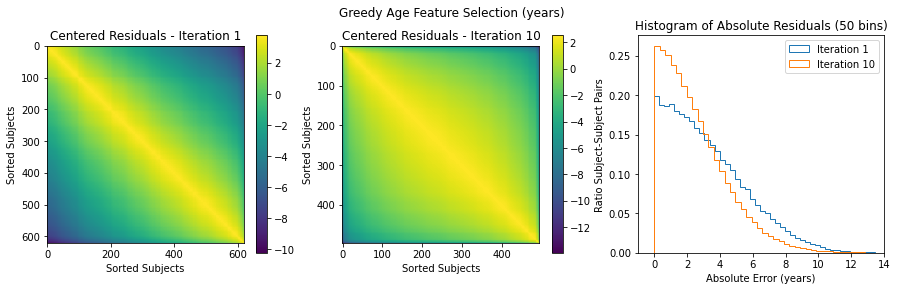

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15,4))

mts = mats[0].detach().cpu().numpy()/12
mts_flat = mts[0,0] - mts.reshape(-1)

mts1 = mats1.detach().cpu().numpy()/12
mts1_flat = mts1[0,0] - mts1.reshape(-1)

mts10 = mats10.detach().cpu().numpy()/12
mts10_flat = mts10[0,0] - mts10.reshape(-1)

im = ax[0].imshow(mts)
fig.colorbar(mappable=im, ax=ax[0])
ax[0].set_xlabel('Sorted Subjects')
ax[0].set_ylabel('Sorted Subjects')
ax[0].set_title('Centered Residuals - Iteration 1')
im = ax[1].imshow(mts10)
fig.colorbar(mappable=im, ax=ax[1])
ax[1].set_xlabel('Sorted Subjects')
ax[1].set_ylabel('Sorted Subjects')
ax[1].set_title('Centered Residuals - Iteration 10')
ax[2].set_title('Histogram of Absolute Residuals (50 bins)')
fig.suptitle('Greedy Age Feature Selection (years)')
ax[2].hist(mts1_flat, bins=50, density=True, histtype='step', label='Iteration 1')
ax[2].hist(mts10_flat, bins=50, density=True, histtype='step', label='Iteration 10')
ax[2].set_xlim([-1,14])
ax[2].set_xlabel('Absolute Error (years)')
ax[2].set_ylabel('Ratio Subject-Subject Pairs')
ax[2].legend()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/LatSimRevision/ResidualsAge.pdf')
fig.show()

In [88]:
with open('../../Work/LatentSim/GreedMasks/AgeMask0.pkl', 'rb') as f:
    mats = pickle.load(f)
    
print(mats.shape)
print('Complete')

torch.Size([496, 496])
Complete


In [26]:
with open('../../Work/LatentSim/GreedMasks/WratMask10Emoid.pkl', 'wb') as f:
    pickle.dump(mats[0], f)
    
print('Complete')

Complete


In [32]:
idcs = torch.argsort(var)
step = 200
regionEval = []

for Y in [nback_p_t[trainIdcs][idcs], emoid_p_t[trainIdcs][idcs]]:
    parts = []
    for j in range(0,40000,step):
        if j >= Y.shape[1]:
            break
        part = Y[:,j:j+step]
        corrSim = torch.einsum('ab,db->adb', part, part)
        corr2 = torch.einsum('adb,ad->b', corrSim, mats[0])
        parts.append(corr2.detach().cpu().numpy())

    parts = np.concatenate(parts)
    regionEval.append(parts)

regionEval = np.stack(regionEval)

print('Complete')

/opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [94,0,0], thread: [32,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [94,0,0], thread: [33,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [94,0,0], thread: [34,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [94,0,0], thread: [35,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811797118/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): blo

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [159]:
# regionEval = np.sum(regionEval, axis=0)
idcs = np.argsort(regionEval, axis=1)

print(idcs[:,-5:])
print(regionEval[0,idcs[0,-5:]])
print(regionEval[1,idcs[1,-5:]])

[[26032 33816 15376 12949 10372]
 [20012 26032  6706 33816 10372]]
[1223541.4 1260620.6 1269727.  1275899.4 1430308.2]
[1066025.1 1094942.5 1100401.8 1144762.  1160336. ]


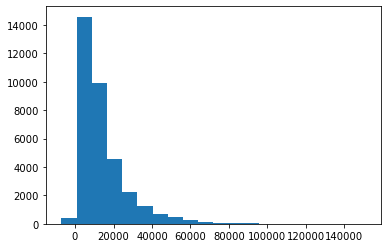

In [144]:
plt.hist(regionEval[0], bins=20)
plt.show()

In [104]:
with open('../../Work/LatentSim/GreedMasks/GenderHist6Emoid.pkl', 'wb') as f:
    pickle.dump(regionEval[1], f)
    
print('Complete')

Complete


In [15]:
# Update regions

# rnback = torch.tensor([10372, 16763, 6732, 5583, 2648, 20011, 458, 353, 1225, 11023], dtype=int)
# remoid = torch.tensor([10372, 17428, 31165, 13599, 2648, 31850, 2159, 9850, 4316, 9004], dtype=int)
# rnback = torch.tensor([646,678,22330,747,616,612], dtype=int)
# remoid = torch.tensor([31728,9534,26653,2058,22176,26761], dtype=int)
# rnback = torch.tensor([646,678,22330,747,616,612,20736,20393,18253,918])
# remoid = torch.tensor([31728,9534,26653,2058,22176,26761,30451,11501,6847,25337])
rnback = torch.tensor([8817,24832,10407,22793,7585,6320,16760,27127,32928,6726])
remoid = torch.tensor([11041,28176,20542,31376,31068,1967,27550,1671,12871,7218])

X0 = nback_p_t[:,rnback]
X1 = emoid_p_t[:,remoid]
Xreg = torch.stack([X0,X1], dim=1)

print('Complete')
print(Xreg.shape)

Complete
torch.Size([620, 2, 10])


In [16]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, inp, edp=0.1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(1e-4*torch.randn(nTgts,inp.shape[-1],2).float().cuda())
        self.edp = nn.Dropout(p=edp)
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        res = []
        es = []
        for i in range(self.active.shape[0]):
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 15000
pPeriod = 500
thresh = 100

rmse = []

sim = LatSim(2, Xreg, 0) # 0.2 wrat, 0.1 other
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

Xt = Xreg[trainIdcs]
Xv = Xreg[validIdcs]

trainLoss = []
validLoss = []

vIdcs1 = np.arange(496,len(validIdcs))
vIdcs2 = validIdcs[496:]
vIdcs3 = np.concatenate([testIdcs, vIdcs2])

var = wrt_t

for epoch in range(nEpochs):
    optim.zero_grad()
    res, _ = sim(Xt, var[trainIdcs])
    avg = torch.mean(torch.stack(res), dim=0)
    loss = 0
    for r in res + [avg]:
        loss += mseLoss(r, var[trainIdcs])
    loss = torch.stack([loss/(len(res)+1)])
    torch.sum(loss).backward()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
        print(f'epoch {epoch} loss={(float(loss))}')
        lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
        if len(validLoss) == 0 or lossV < min(validLoss):
            print(f'New best validation epoch {epoch} loss={lossV}')
            torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
        validLoss.append(lossV)
        if torch.all(loss[0:3] < thresh):
            print('Early stopping')
            break

print('Finished training')

sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
loss = validate(sim, Xreg, var, testIdcs)

rmse.append((float(loss)))

# print(i, end=' ')
print(rmse[-1])

epoch 0 loss=260.850830078125
New best validation epoch 0 loss=11.892563819885254
epoch 500 loss=245.23684692382812
New best validation epoch 500 loss=11.751410484313965
epoch 1000 loss=214.1497039794922
New best validation epoch 1000 loss=11.655214309692383
epoch 1500 loss=192.4834442138672
epoch 2000 loss=182.99203491210938
epoch 2500 loss=179.2635955810547
epoch 3000 loss=177.64390563964844
epoch 3500 loss=176.80908203125
epoch 4000 loss=176.31387329101562
epoch 4500 loss=176.00997924804688
epoch 5000 loss=175.8330535888672
epoch 5500 loss=175.74017333984375
epoch 6000 loss=175.6984100341797
epoch 6500 loss=175.68331909179688
epoch 7000 loss=175.6792449951172
epoch 7500 loss=175.6780242919922
epoch 8000 loss=175.66632080078125
epoch 8500 loss=175.40660095214844
epoch 9000 loss=174.7076873779297
epoch 9500 loss=174.35479736328125
epoch 10000 loss=174.2218017578125
epoch 10500 loss=174.12911987304688
epoch 11000 loss=173.65658569335938
epoch 11500 loss=172.9371795654297
epoch 12000 lo

In [17]:
# r0 = F.one_hot(torch.argmax(res[0], dim=1), 2)
# r1 = F.one_hot(torch.argmax(res[1], dim=1), 2)
# ra = F.one_hot(torch.argmax(avg, dim=1), 2)

# ynback = var[trainIdcs]-r0
# yemoid = var[trainIdcs]-r1
# yavg = var[trainIdcs]-ra

# print(var[trainIdcs][:10,:])
# print(r0[:50,:])

# plt.stem(yavg.detach().cpu().numpy()[:,1])
# plt.show()

ynback = var[trainIdcs]-res[0]
yemoid = var[trainIdcs]-res[1]
yavg = var[trainIdcs]-avg

# print(sim.active)

# plt.plot(ynback.detach().cpu().numpy()/12, label='nback')
# plt.plot(yemoid.detach().cpu().numpy()/12, label='emoid')
# plt.plot(yavg.detach().cpu().numpy()/12, label='avg')
# plt.show()

In [148]:
ynback

tensor([ 8.8052e+00,  4.0638e+01, -1.1358e+01,  1.6497e+00, -4.5499e-01,
        -5.9755e+00,  2.2025e+01,  1.0756e+00, -7.5228e+00, -3.5593e+00,
        -3.8353e+00, -2.2875e+01, -1.1325e+01, -1.6915e+01, -1.2076e+00,
         2.9382e+00, -8.9644e+00,  3.1151e+01,  9.2030e+00, -1.0267e+01,
        -1.4991e+01,  6.8692e+00, -9.9239e+00, -2.7010e+01,  8.8754e+00,
         8.6140e+00, -1.0773e+01,  2.3064e+00, -2.0513e+00, -8.0458e+00,
        -1.0051e+01,  3.1809e+00,  1.1909e+00,  1.3743e+01, -2.9988e+00,
        -1.5765e+01, -1.1861e+00,  8.8298e+00, -1.6298e+01,  4.7976e+00,
        -6.2990e+00, -1.0449e+00, -1.5265e+01, -7.5012e+00,  1.8396e+00,
        -5.8985e+00,  1.8557e+01,  3.5015e+00,  7.0599e+00,  2.4805e+01,
         3.0671e+01,  1.4462e+01, -1.3748e+01,  5.6175e+00,  2.6192e+01,
        -1.5037e+01, -2.6359e+01, -2.0127e+01,  2.3027e+01, -1.3771e+01,
        -8.9990e+00,  1.5400e+01, -2.6687e+00,  3.9531e+01,  1.3286e+00,
        -1.4539e+01,  1.1389e+01,  4.2505e+01, -8.9

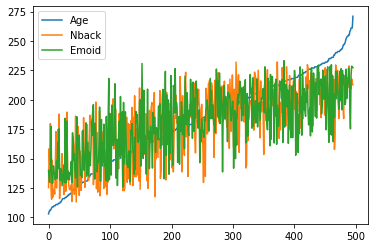

In [472]:
idcs = torch.argsort(var[trainIdcs])

plt.plot(var[trainIdcs][idcs].detach().cpu().numpy(), label='Age')
plt.plot(res[0][idcs].detach().cpu().numpy(), label='Nback')
plt.plot(res[1][idcs].detach().cpu().numpy(), label='Emoid')
plt.legend()
plt.show()

In [356]:
Y, _, E = sim.getLatentsAndEdges(Xt[:,1,:], 1)
print(E)

tensor([[ 0.1554,  0.4813, -0.5282,  ..., -0.6564,  0.4877,  0.0632],
        [ 0.4813,  1.4907, -1.6360,  ..., -2.0330,  1.5106,  0.1958],
        [-0.5282, -1.6360,  1.7953,  ...,  2.2311, -1.6578, -0.2148],
        ...,
        [-0.6564, -2.0330,  2.2311,  ...,  2.7726, -2.0601, -0.2670],
        [ 0.4877,  1.5106, -1.6578,  ..., -2.0601,  1.5308,  0.1984],
        [ 0.0632,  0.1958, -0.2148,  ..., -0.2670,  0.1984,  0.0257]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [33]:
import scipy.stats

a = (29.36062431,
34.29428101,
30.47612381,
28.52052307,
29.08536339,
27.48115158,
31.54662895,
29.66555786,
28.01536369,
29.347435)

b = (32.66127014,
34.82040024,
28.67077827,
30.07994843,
31.85699081,
29.12542152,
32.9060936,
32.40882492,
29.05584908,
33.08743286)

_, p = scipy.stats.ttest_rel(a, b)
print(p)

0.008872284607030753
